ECE 447: Second Order Systems
===

Prof. Eric Klavins

&copy; 2019, University of Washington

# Code

In [64]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

def center(plt):
    plt.gca().spines['left'].set_position('center')
    plt.gca().spines['bottom'].set_position('center')
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.gca().set_aspect('equal') 
    
def poles(plt,poles):
    center(plt)
    for p in poles:
        plt.plot([p[0]-0.1,p[0]+0.1],[p[1]-0.1,p[1]+0.1],'black')
        plt.plot([p[0]-0.1,p[0]+0.1],[p[1]+0.1,p[1]-0.1],'black')   
        plt.xlabel("Im", labelpad=100)
        plt.ylabel("Re", labelpad=140)        

# Goal

Here, our goal is to find the exact solution of a typical second order system with two poles and no zeros. With the exact solution, we will be able to look precisely at metrics like rise time, overshoot, and settling time. Although not every system is a second order system with one zero, we will (later) see that by placing the two dominant poles of a system carefully, that we can make even higher order systems behave approximately like the system we will study here.

# The Archetypal System

Consider the system

$$
T(s) = \frac{\omega^2}{s^2 + 2 \zeta \omega + \omega^2}
$$

where $\zeta \geq 0$ and $\omega \geq 0$ are constants that depend on whatever physical parameters of the system are present. This is the general form a system with two poles and no zeros.

The poles are the roots of the denominator of $T(s)$ and are found using the quadratic formula:

$$
\frac{-2 \zeta \omega \pm \sqrt{4 \zeta^2 \omega^2 - 4 \omega^2}}{2}
$$

which simplifies to 

\begin{align}
 & \; -\omega\zeta \pm \omega \sqrt{\zeta^2 - 1} \\
 & = - \omega\zeta \pm \omega \beta
\end{align}

where $\beta = \sqrt{\zeta^2 - 1}$.

In the s-plane this looks like:

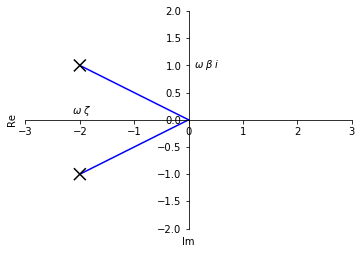

In [70]:
plt.xlim(-3,3)
plt.ylim(-2,2)
plt.plot([-2,0],[1,0],'blue')
plt.plot([-2,0],[-1,0],'blue')
poles(plt,[[-2,1],[-2,-1]])
x1 = plt.Text(0.1,0.95, "$\omega\;\\beta\;i$")
x2 = plt.Text(-2.15,0.1, "$\omega\;\\zeta$")
plt.gca().add_artist(x1)
plt.gca().add_artist(x2);

The parameter $\zeta$ is called the **damping ratio**:

- $\zeta = 0 \; \Rightarrow$ pure oscillations
- $\zeta = 1 \; \Rightarrow$ critically damped

The parameter $\omega$ is called the **natural frequency**.

# The Step Response

To learn more about the behavior of the archetypal system, we'll find its step response.

In [269]:
# Declare variables
var("s")
var("w z t b tau theta", real=True, positive=True)
T = (w**2)/(s**2 + 2*z*w*s + w**2)

In [110]:
# Unfortunately, sympy gives us a fairly unintutitive expression
inverse_laplace_transform(T,s,t)

  ⎛         _______    ⎛atan2(0, z - 1)⎞   _________                          
  ⎜   t⋅w⋅╲╱ z + 1 ⋅cos⎜───────────────⎟⋅╲╱ │z - 1│                           
  ⎜                    ⎝       2       ⎠                ⎛      _______    ⎛ata
w⋅⎜ⅈ⋅ℯ                                              ⋅sin⎜t⋅w⋅╲╱ z + 1 ⋅sin⎜───
  ⎝                                                     ⎝                 ⎝   
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              
                                                                              

                                    _______    ⎛atan2(0, z - 1)⎞   _________  
                              t⋅w⋅╲╱ z + 1 ⋅cos⎜───────────────⎟⋅╲╱ │z - 1│   
n2(0, z - 1)⎞   _________⎞                     ⎝       2       ⎠              
────────────⎟⋅╲╱ │z - 1│ ⎟ + ℯ                     

In [111]:
# Can represent the system in state space though
A = Matrix([
    [-w*z, -w*b],
    [w*b,-w*z]
])
B=Matrix([
    [w],
    [0]
])
C = Matrix([[0,1/b]])

In [112]:
# Let's check that this gives us the same transfer function back
Tcheck = C*(s*eye(2)-A).inv()*B
Tcheck

⎡               2             ⎤
⎢              w              ⎥
⎢─────────────────────────────⎥
⎢          ⎛  2  2           ⎞⎥
⎢          ⎜ b ⋅w            ⎟⎥
⎢(s + w⋅z)⋅⎜─────── + s + w⋅z⎟⎥
⎣          ⎝s + w⋅z          ⎠⎦

In [113]:
# The above looks close, but we need to put in the definition of beta
Tcheck = Tcheck.subs(b,sqrt(1-z**2))
Tcheck.simplify()
Tcheck

⎡         2       ⎤
⎢        w        ⎥
⎢─────────────────⎥
⎢ 2              2⎥
⎣s  + 2⋅s⋅w⋅z + w ⎦

In [ ]:
# Now let's find the response. First note that although
#
#   y = y_natural    + y_forced
#     = C * eAt * x0 + y_forced
#
# we are assuming that x0 = [0,0]^T, so y_natural = 0 so 
#
#   y = y_forced
#
# Unfortunately, sympy thrashes on the following integration problem:
# 
integrate(C*exp(A*(t-tau))*B*1,(tau,0,t))

In [149]:
# But we can break it down
P, D = A.diagonalize()
P,D

⎛⎡-ⅈ  ⅈ⎤, ⎡-ⅈ⋅b⋅w - w⋅z       0     ⎤⎞
⎜⎢     ⎥  ⎢                         ⎥⎟
⎝⎣1   1⎦  ⎣     0        ⅈ⋅b⋅w - w⋅z⎦⎠

Now we use the fact that

$$
y = \int_0^t C P e^{D(t-\tau)}P^{-1}B d \tau
$$

with $CP$ and $P^{-1}B$ just constants.

In [203]:
# Using the above gives use a pretty simple expression for the integrand
temp1 = C*P*exp(D*t)*P.inv()*B
temp1 = temp1[0,0].simplify()
temp1

    ⎛ t⋅w⋅(-ⅈ⋅b - z)    t⋅w⋅(ⅈ⋅b - z)⎞
ⅈ⋅w⋅⎝ℯ               - ℯ             ⎠
──────────────────────────────────────
                 2⋅b                  

In [204]:
# It can be rewritten in terms of sin
temp2 = temp1.rewrite(sin).simplify()
temp2

   -t⋅w⋅z           
w⋅ℯ      ⋅sin(b⋅t⋅w)
────────────────────
         b          

In [222]:
# We can then try to integrate it, but it doesn't seem to work
temp3 = temp2.subs(t,t-tau)
integrate(temp3,(tau,0,t))

          t                             
          ⌠                             
   -t⋅w⋅z ⎮  τ⋅w⋅z                      
w⋅ℯ      ⋅⎮ ℯ     ⋅sin(b⋅t⋅w - b⋅τ⋅w) dτ
          ⌡                             
          0                             
────────────────────────────────────────
                   b                    

In [227]:
# But we can give sympy some help
y = integrate(temp3.expand(tau),(tau,0,t))
y.simplify()
y

                ⎛b⋅cos(b⋅t⋅w)   z⋅sin(b⋅t⋅w)⎞  -t⋅w⋅z
              w⋅⎜──────────── + ────────────⎟⋅ℯ      
                ⎜ 2        2     2        2 ⎟        
     w          ⎝b ⋅w + w⋅z     b ⋅w + w⋅z  ⎠        
─────────── - ───────────────────────────────────────
 2        2                      b                   
b ⋅w + w⋅z                                           

In [259]:
# Note that b^2 + z^2 = 1-z^2 + z^2 = 1
y = y.subs(w*b**2+w*z**2,w).simplify().cancel()
y

 ⎛     t⋅w⋅z                              ⎞  -t⋅w⋅z 
-⎝- b⋅ℯ      + b⋅cos(b⋅t⋅w) + z⋅sin(b⋅t⋅w)⎠⋅ℯ       
────────────────────────────────────────────────────
                         b                          

Now consider a right triangle with sides $\zeta$ and $\beta$. Then since $\zeta^2 + \beta^2 = 1$, we get:

$$
\cos \theta = \zeta
$$

$$
\sin \theta = \beta
$$

where

$$
\theta = \cos^{-1} \zeta .
$$

We can then use the trig identity

$$
\sin(a + \theta) = \sin a \cos \theta + \sin \theta \cos a
$$

with a = $\beta \omega t$. 

The above expression thus becomes

$$
y(t) = 1 - \frac{1}{\beta} e^{-\zeta \omega t} \sin(\omega \beta t + \theta)
$$

# What does it look like?

In [308]:
y = 1 - (1/b) * exp(-z*w*t) * sin(w * b * t + theta)
y = y.subs(b,sqrt(1-z**2)).subs(theta,acos(z))

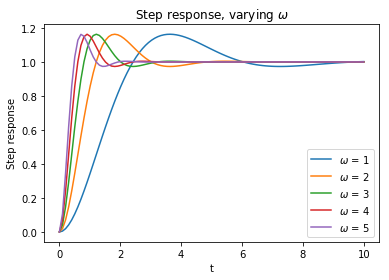

In [341]:
#
# Fixed zeta, varying omega
#
tvals = np.linspace(0,10,100)
for omega in [1,2,3,4,5]:
    f = lambdify(t,y.subs(z,0.5).subs(w,omega),'numpy')
    plt.plot(tvals,f(tvals),label="$\omega$ = %d" % omega)
plt.xlabel("t")
plt.ylabel("Step response")
plt.title("Step response, varying $\omega$")
plt.legend();

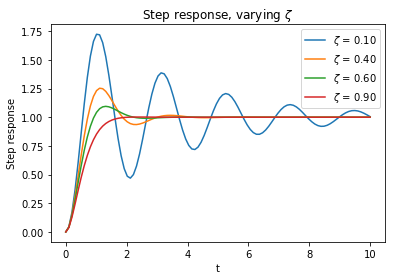

In [340]:
#
# Fixed omega, varying zeta
#
tvals = np.linspace(0,10,100)
for zeta in [0.1,0.4,0.6,0.9]:
    f = lambdify(t,y.subs(z,zeta).subs(w,3),'numpy')
    plt.plot(tvals,f(tvals),label="$\zeta$ = %.2f" % zeta)
plt.xlabel("t")
plt.ylabel("Step response")
plt.title("Step response, varying $\zeta$")
plt.legend();

# The Impulse Response

The impulse response can easily be obtained from the step response using the fact that 

$$
\mathcal{L}[y(t)] = Y(s) = \frac{1}{s}T(s)
$$

so that

$$
\mathcal{L}[\dot y(t)] = s Y(s) = 1 T(s) = T(s)
$$

So the Laplace transform of the impulse response is just the derivative of

$$
y = \int_0^t C P e^{D(t-\tau)}P^{-1}B d \tau
$$

which is

$$
\dot y = C P e^{Dt}P^{-1}B
$$

which we already found to be 

$$
\dot y = \frac{\omega}{\beta} e^{-\zeta \omega t} \sin(\omega \beta t)
$$

In [332]:
ydot = (w/b)*exp(-z*w*t)*sin(w*b*t)
ydot = ydot.subs(b,sqrt(1-z**2))

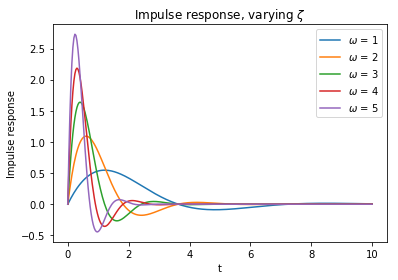

In [339]:
#
# Fixed zeta, varying 
#
tvals = np.linspace(0,10,300)
for omega in [1,2,3,4,5]:
    fdot = lambdify(t,ydot.subs(z,0.5).subs(w,omega),'numpy')
    plt.plot(tvals,fdot(tvals),label="$\omega$ = %d" % omega)
plt.xlabel("t")
plt.ylabel("Impulse response")
plt.title("Impulse response, varying $\zeta$")
plt.legend();

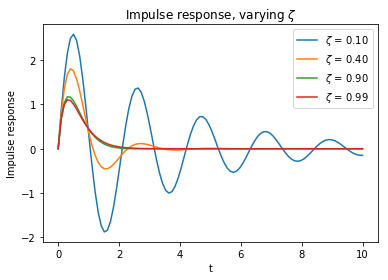

In [338]:
#
# Fixed w, z 
#
tvals = np.linspace(0,10,100)
for zeta in [0.1,0.4,0.9,0.99]:
    fdot = lambdify(t,ydot.subs(z,zeta).subs(w,3),'numpy')
    plt.plot(tvals,fdot(tvals),label="$\zeta$ = %.2f" % zeta)
plt.xlabel("t")
plt.ylabel("Impulse response")
plt.title("Impulse response, varying $\zeta$")
plt.legend();